In [1]:
import os
cwd = os.getcwd()
cwd

'c:\\Users\\marta\\Documents\\School\\Natural Computing\\artistoo\\examples\\node'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Step 1: Load Data (same as before)
def load_cell_data(file_paths):
    all_positions = {}
    for file_path in file_paths:
        try:
            cell_id = file_path.split('/')[-1].split('.')[0]  # Extract cell id from filename
            data = np.loadtxt(file_path, delimiter=',')  # Assuming data is in two columns (x, y)
            all_positions[cell_id] = data
        except:
            print(f"{file_path} not found")
    return all_positions

# Step 2: Calculate Centroid of the Group
def calculate_centroid(positions):
    centroid = np.mean(positions, axis=0)  # Mean of x and y over all cells at each timestep
    return centroid

# Step 3: Calculate Displacement for Each Cell
def calculate_displacement(cell_positions):
    displacements = np.linalg.norm(np.diff(cell_positions, axis=0), axis=1)  # Euclidean distance between consecutive timesteps
    return displacements

# Step 4: Cluster Cells Over Time (DBSCAN)
def cluster_cells(all_positions, eps=0.1, min_samples=10):
    all_positions_concat = np.concatenate([positions for positions in all_positions.values()], axis=0)  # Concatenate all positions
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(all_positions_concat)
    labels = db.labels_  # Get cluster labels for each point
    return labels, all_positions_concat


In [3]:
# Example Usage
n=0
file_paths = [f'output/img/trackobstacles-trackall{n}/position{i}.txt' for i in range(1,1002)]  # Replace with actual file paths
all_positions = load_cell_data(file_paths)
# plot_trajectories(all_positions)

output/img/trackobstacles-trackall0/position21.txt not found
output/img/trackobstacles-trackall0/position26.txt not found
output/img/trackobstacles-trackall0/position44.txt not found
output/img/trackobstacles-trackall0/position49.txt not found
output/img/trackobstacles-trackall0/position97.txt not found
output/img/trackobstacles-trackall0/position108.txt not found
output/img/trackobstacles-trackall0/position113.txt not found
output/img/trackobstacles-trackall0/position122.txt not found
output/img/trackobstacles-trackall0/position126.txt not found
output/img/trackobstacles-trackall0/position135.txt not found
output/img/trackobstacles-trackall0/position158.txt not found
output/img/trackobstacles-trackall0/position187.txt not found
output/img/trackobstacles-trackall0/position188.txt not found
output/img/trackobstacles-trackall0/position192.txt not found
output/img/trackobstacles-trackall0/position198.txt not found
output/img/trackobstacles-trackall0/position226.txt not found
output/img/tr

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_centroid_movement(all_positions):
    """
    Plots the movement of the group's centroid over time and annotates the plot with time labels
    at every 500 time units.
    
    :param all_positions: Dictionary with cell_id as keys and 2D arrays of positions as values.
    """
    # Calculate centroids for each timestep
    centroids = [calculate_centroid(positions) for positions in zip(*all_positions.values())]  # Centroid at each timestep
    centroids = np.array(centroids)

    # Create the plot
    plt.figure(figsize=(8, 6))
    
    # datafile = 'output/img/empty/trackposition-t0.png'
    # img = plt.imread(datafile)
    # plt.imshow(img, zorder=0, extent=[0.0, 500.0, 0.0, 500.0])
    
    plt.plot(centroids[:, 0], centroids[:, 1], label='Group Centroid', color='blue', linewidth=2)

    # Add time labels every 500 time units
    time_intervals = range(0, len(centroids), 500)  # Adjust step if needed (500 is the interval)
    for t in time_intervals:
        plt.text(centroids[t, 0], centroids[t, 1], f'time={t}', fontsize=8, ha='right', color='red')

    # # Plot labels and title
    # plt.xlim((0,500))
    # plt.ylim((0,500))
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title('Group Movement (Centroid)')

    # Show the plot
    plt.savefig("../../figures/10x10-field-1000-cells-5000-timeunits-migration.png", bbox_inches='tight', pad_inches = 0)

# Example of how to call the function
# plot_centroid_movement(all_positions)  # Where all_positions is a dictionary of cell positions


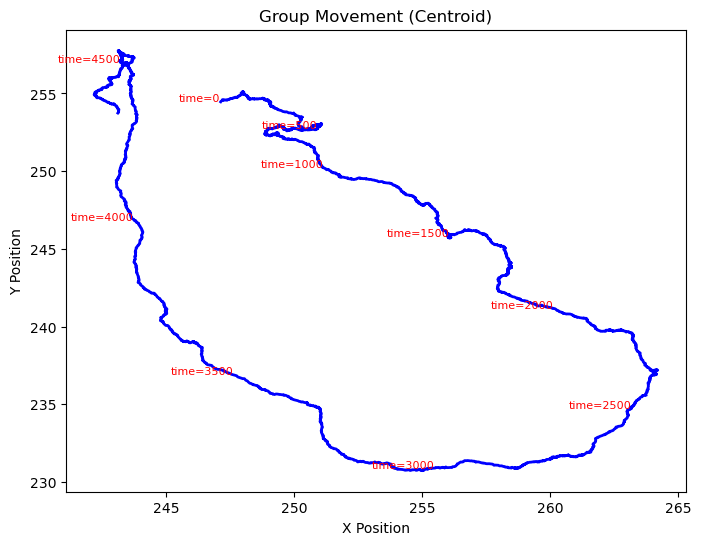

In [20]:
plot_centroid_movement(all_positions)

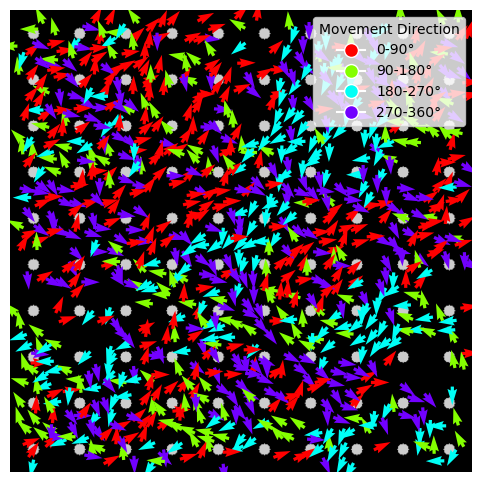

In [18]:
import numpy as np
import matplotlib.pyplot as plt


# Step 2: Calculate Direction of Movement at the Final Timestep
def calculate_direction_of_movement(positions, n_last_positions=10):
    """
    Calculate the direction of movement of a cell using the last `n_last_positions` timesteps.
    
    :param positions: A 2D array (timesteps x 2) of cell positions.
    :param n_last_positions: The number of last positions to consider for calculating the direction.
    :return: Angle of movement in degrees based on the last `n_last_positions` positions.
    """
    # Ensure we have enough positions to calculate direction
    if len(positions) < n_last_positions:
        raise ValueError(f"Not enough positions. Need at least {n_last_positions} timesteps.")

    # Get the last `n_last_positions` positions
    recent_positions = positions[-n_last_positions:]

    # Calculate the difference between the first and last position in the selected subset
    start_position = recent_positions[0]
    end_position = recent_positions[-1]
    
    # Calculate the vector from start to end position
    delta_x = end_position[0] - start_position[0]
    delta_y = end_position[1] - start_position[1]

    # Compute the angle of the movement (in radians)
    angle = np.arctan2(delta_y, delta_x)  # Angle in radians

    # Convert to degrees
    angle_deg = np.degrees(angle)

    # Normalize angle to be between 0 and 360
    if angle_deg < 0:
        angle_deg += 360

    return angle_deg

# Step 3: Plot Final Positions and Direction Arrows with Color Based on Direction
def plot_final_positions_with_direction(all_positions):
    """
    Plot the final positions of all cells and represent their movement direction using arrows, 
    while coloring cells based on their movement direction.
    
    :param all_positions: Dictionary with cell_id as keys and 2D arrays of positions as values.
    """
    # Categories of direction (split into 8 categories, 45-degree intervals)
    direction_categories = np.linspace(0, 360, 5)  # 8 categories from 0 to 360 degrees
    
    # Initialize the plot
    plt.figure(figsize=(8, 6))
    datafile = 'output/img/onlyobstacles/trackposition-t0.png'
    img = plt.imread(datafile)
    plt.imshow(img, zorder=0, extent=[0.0, 500.0, 0.0, 500.0])
    # Prepare the legend labels for each direction category
    direction_labels = [
        "0-90°", "90-180°",
        "180-270°", "270-360°"
    ]
    
    # Initialize a list to hold the data for arrows
    directions = []
    dx = []
    dy = []
    x_pos = []
    y_pos = []
    colors = plt.cm.hsv(np.linspace(0, 1, 5))  # Use HSV colormap for smooth color transitions

    # Plot final positions and direction arrows for each cell
    for cell_id, positions in all_positions.items():
        # Calculate the direction of movement at the final timestep
        direction = calculate_direction_of_movement(positions)
        directions.append(direction)
        # Convert the direction to radians
        direction_rad = np.radians(direction)
        
        # Get the final position (last timestep) of the cell
        final_position = positions[-1]
        
        # Arrow components: direction of movement (dx, dy)
        arrow_length = 20  # Increase the arrow length to make the arrows 10x bigger
        dx.append(arrow_length * np.cos(direction_rad))
        dy.append(arrow_length * np.sin(direction_rad))
        
        # Final position to place the arrows
        x_pos.append(final_position[0])
        y_pos.append(final_position[1])

        # Determine the color based on direction category
        category_index = np.digitize(direction, direction_categories) - 1  # Get the index of the category
        category_index = max(0, min(category_index, 7))  # Ensure the index is between 0 and 7
        #plt.scatter(final_position[0], final_position[1], color=colors[category_index], s=20)

    # Step 4: Plot arrows representing direction using quiver
    
    color_quivers = [colors[np.digitize(x, direction_categories) - 1] for x in directions]
    plt.quiver(x_pos, y_pos, dx, dy, angles='xy', scale_units='xy', scale=1, color=color_quivers, alpha=1, width=0.007)

    # Add labels and title
    plt.xlabel('X Position')
    plt.ylabel('Y Position')

    # Create a custom legend for the direction categories
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
               for color in colors]
    plt.legend(handles, direction_labels, title="Movement Direction", loc='upper right', bbox_to_anchor=(1, 1))
    
    # Show the plot
    plt.axis('off')
    plt.savefig("../../figures/10x10-field-1000-cells-5000-timeunits-directionality.png", bbox_inches='tight', pad_inches = 0)

plot_final_positions_with_direction(all_positions)


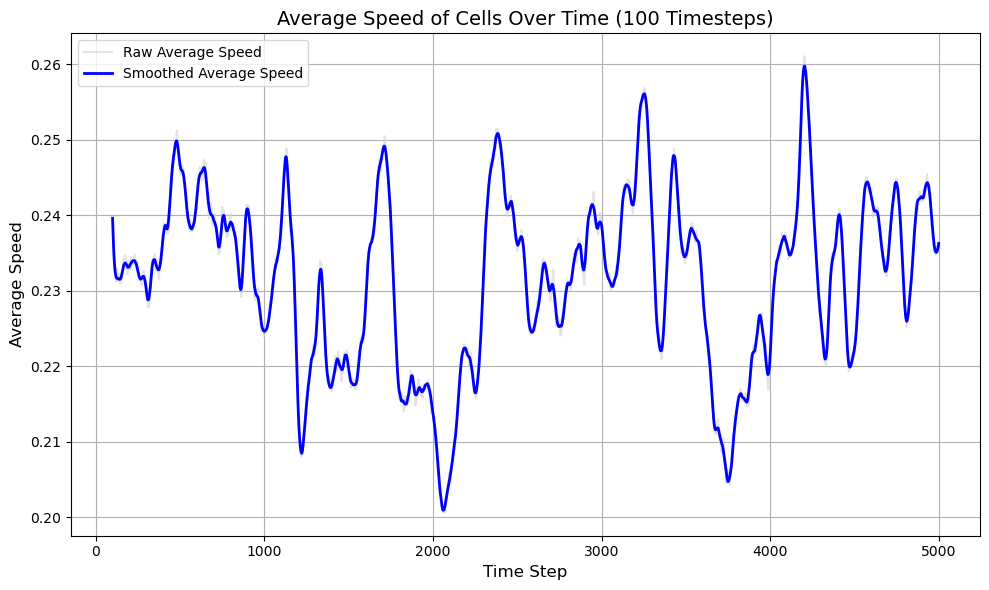

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

def calculate_speed(positions, window_size=10):
    """
    Calculates the average Euclidean distance traveled per timestep over a given window of timesteps for each cell.
    
    :param positions: A 2D numpy array (timesteps x 2) representing the (x, y) positions of the cell.
    :param window_size: The number of timesteps over which to calculate the average speed (default is 10).
    :return: A 1D numpy array of average speeds (timesteps - window_size + 1) for each cell.
    """
    speeds = []
    
    # Calculate average speed over the window size
    for t in range(window_size, len(positions)):
        # Calculate the total distance over the window (from t - window_size to t)
        distance_travelled = np.sqrt(np.sum(np.diff(positions[t - window_size:t], axis=0) ** 2))
        
        # Calculate the average speed over the window (total distance / window size)
        avg_speed = distance_travelled / window_size
        speeds.append(avg_speed)
        
    return np.array(speeds)

def calculate_average_speed(all_positions, window_size=10):
    """
    Calculates the average speed of all cells over a given window size at each timestep.
    
    :param all_positions: A dictionary with cell ids as keys and arrays of positions at each timestep as values.
    :param window_size: The number of timesteps over which to calculate the average speed (default is 10).
    :return: A list of average speeds over time.
    """
    num_timesteps = len(next(iter(all_positions.values())))
    speeds_over_time = []

    # Loop over each timestep, starting from the window_size timestep (to ensure we have enough data)
    for t in range(window_size, num_timesteps):
        total_speed_at_t = 0
        
        for cell_positions in all_positions.values():
            # Calculate the average speed for each cell between timestep t-window_size and t
            avg_speed = np.linalg.norm(cell_positions[t] - cell_positions[t - window_size]) / window_size  # Speed over window size timesteps
            total_speed_at_t += avg_speed
        
        # Calculate the average speed at this timestep
        avg_speed_at_t = total_speed_at_t / len(all_positions)
        speeds_over_time.append(avg_speed_at_t)

    return speeds_over_time

# Example of using the function
# Assuming `all_positions` is already defined and contains the cell positions over time

window_size = 100  # Define the window size to calculate speed over 100 timesteps
average_speeds = calculate_average_speed(all_positions, window_size)

# Apply Savitzky-Golay filter for smoothing the speed data
smoothed_speeds = savgol_filter(average_speeds, window_length=51, polyorder=3)

# Plotting the graph
plt.figure(figsize=(10, 6))

# Plot the original average speed
# Here we plot starting from `window_size` since the first speed value corresponds to the window
plt.plot(range(window_size, len(average_speeds) + window_size), average_speeds, label='Raw Average Speed', color='lightgray', linestyle='-', alpha=0.6)

# Plot the smoothed average speed
plt.plot(range(window_size, len(smoothed_speeds) + window_size), smoothed_speeds, label='Smoothed Average Speed', color='blue', linewidth=2)

# Labeling the axes
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Average Speed', fontsize=12)

# Title and additional info
plt.title(f'Average Speed of Cells Over Time ({window_size} Timesteps)', fontsize=14)
plt.grid(True)

# Adding a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.savefig("../../figures/10x10-field-1000-cells-5000-timeunits-speed.png", bbox_inches='tight', pad_inches = 0)